In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_error, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, Normalizer
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from os import path

In [2]:
datos = pd.read_csv("20220617_NEM_PERCENTILES_JOVENES_2021_20220530_PUBL.csv", sep=";")

In [3]:
datos

,RBD,COD_DEPE,AGNO_EGRESO,MRUN,NEM,PERCENTIL,PUESTO_10,PUESTO_30
0,8424,1,2021,122,"5,78",30,NO,SI
1,2200,4,2021,163,"6,85",20,NO,SI
2,40023,4,2021,164,"6,53",40,NO,NO
3,8923,4,2021,429,"6,7",60,NO,NO
4,10500,3,2021,488,"5,3",60,NO,NO
...,...,...,...,...,...,...,...,...
207697,286,1,2021,27072968,"6,2",10,SI,NO
207698,109,1,2021,27072971,"5,03",90,NO,NO
207699,106,5,2021,27072972,"5,33",80,NO,NO
207700,11831,1,2021,27072973,"6,08",20,NO,SI


In [4]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207702 entries, 0 to 207701
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   RBD          207702 non-null  int64 
 1   COD_DEPE     207702 non-null  int64 
 2   AGNO_EGRESO  207702 non-null  int64 
 3   MRUN         207702 non-null  int64 
 4   NEM          207702 non-null  object
 5   PERCENTIL    207702 non-null  int64 
 6   PUESTO_10    207702 non-null  object
 7   PUESTO_30    207702 non-null  object
dtypes: int64(5), object(3)
memory usage: 12.7+ MB


In [5]:
datos["RBD"] = datos["RBD"].astype("category")
datos["NEM"] = datos["NEM"].str.replace(",",".")
datos["NEM"] = datos["NEM"].astype(np.float64)


In [6]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207702 entries, 0 to 207701
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   RBD          207702 non-null  category
 1   COD_DEPE     207702 non-null  int64   
 2   AGNO_EGRESO  207702 non-null  int64   
 3   MRUN         207702 non-null  int64   
 4   NEM          207702 non-null  float64 
 5   PERCENTIL    207702 non-null  int64   
 6   PUESTO_10    207702 non-null  object  
 7   PUESTO_30    207702 non-null  object  
dtypes: category(1), float64(1), int64(4), object(2)
memory usage: 11.6+ MB


In [7]:
agrupacion_promedios = datos.groupby(by = "RBD").mean().reset_index()

In [8]:
directorio = pd.read_csv("Directorio_Oficial_EE_2021.csv", sep=";")

In [9]:
directorio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16498 entries, 0 to 16497
Data columns (total 37 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   AGNO            16498 non-null  int64 
 1   RBD             16498 non-null  int64 
 2   DGV_RBD         16498 non-null  int64 
 3   NOM_RBD         16468 non-null  object
 4   MRUN            16498 non-null  object
 5   RUT_SOSTENEDOR  16498 non-null  object
 6   P_JURIDICA      16498 non-null  int64 
 7   COD_REG_RBD     16498 non-null  int64 
 8   NOM_REG_RBD_A   16498 non-null  object
 9   COD_PRO_RBD     16498 non-null  int64 
 10  COD_COM_RBD     16498 non-null  int64 
 11  NOM_COM_RBD     16498 non-null  object
 12  COD_DEPROV_RBD  16498 non-null  int64 
 13  NOM_DEPROV_RBD  16498 non-null  object
 14  COD_DEPE        16498 non-null  int64 
 15  COD_DEPE2       16498 non-null  int64 
 16  RURAL_RBD       16498 non-null  int64 
 17  LATITUD         16498 non-null  object
 18  LONGIT

In [10]:
directorio = directorio[directorio["NOM_RBD"].str.contains("JARDIN+|SALA CUNA+", regex=True) == False]

In [11]:
directorio["LONGITUD"] = directorio["LONGITUD"].replace(" ", np.nan)
directorio["LATITUD"] = directorio["LATITUD"].replace(" ", np.nan)
directorio.dropna()
directorio["LONGITUD"] = directorio["LONGITUD"].str.replace(",",".").astype(np.float64)
directorio["LATITUD"] = directorio["LATITUD"].str.replace(",",".").astype(np.float64)


In [12]:
directorio

,AGNO,RBD,DGV_RBD,NOM_RBD,MRUN,RUT_SOSTENEDOR,P_JURIDICA,COD_REG_RBD,NOM_REG_RBD_A,COD_PRO_RBD,...,ENS_08,ENS_09,ENS_10,ENS_11,MATRICULA,ESTADO_ESTAB,ORI_RELIGIOSA,ORI_OTRO_GLOSA,PAGO_MATRICULA,PAGO_MENSUAL
0,2021,1,9,LICEO POLITECNICO ARICA,,62000660,1,15,AYP,151,...,0,0,0,0,1,1,2,,GRATUITO,GRATUITO
1,2021,2,7,PARVULARIO LAS ESPIGUITAS,,62000660,1,15,AYP,151,...,0,0,0,0,1,1,2,,GRATUITO,GRATUITO
2,2021,3,5,ESC. PEDRO VICENTE GUTIERREZ TORRES,,62000660,1,15,AYP,151,...,0,0,0,0,1,1,1,,GRATUITO,GRATUITO
3,2021,4,3,LICEO OCTAVIO PALMA PEREZ,,62000660,1,15,AYP,151,...,0,0,0,0,1,1,1,,GRATUITO,GRATUITO
4,2021,5,1,JOVINA NARANJO FERNANDEZ,,62000660,1,15,AYP,151,...,0,0,0,0,1,1,7,PLURALISTA,GRATUITO,GRATUITO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16485,2021,41911,7,ESCUELA DE LENGUAJE RUCAKUYÉN,,65095013,1,8,BBIO,81,...,0,0,0,0,0,1,9,,SIN INFORMACION,SIN INFORMACION
16489,2021,41916,8,ESCUELA HOSPITALARIA SAN ANTONIO,,65142404,1,5,VALPO,56,...,0,0,0,0,0,1,1,,SIN INFORMACION,SIN INFORMACION
16490,2021,41917,6,ESCUELA HOSPITALARIA SAN FRANCISCO,,65193679,1,5,VALPO,57,...,0,0,0,0,0,1,9,,GRATUITO,GRATUITO
16492,2021,41919,2,COLEGIO HODGKINSON,,53334410,1,6,LGBO,61,...,0,0,0,0,0,1,9,,SIN INFORMACION,SIN INFORMACION


In [13]:
localizaciones = gpd.GeoDataFrame(directorio, geometry= gpd.points_from_xy(directorio["LONGITUD"], directorio["LATITUD"]), crs=4326)

In [14]:
conjunto = localizaciones.merge(agrupacion_promedios, on = "RBD")

In [15]:
conjunto.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2959 entries, 0 to 2958
Data columns (total 43 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   AGNO            2959 non-null   int64   
 1   RBD             2959 non-null   object  
 2   DGV_RBD         2959 non-null   int64   
 3   NOM_RBD         2959 non-null   object  
 4   MRUN_x          2959 non-null   object  
 5   RUT_SOSTENEDOR  2959 non-null   object  
 6   P_JURIDICA      2959 non-null   int64   
 7   COD_REG_RBD     2959 non-null   int64   
 8   NOM_REG_RBD_A   2959 non-null   object  
 9   COD_PRO_RBD     2959 non-null   int64   
 10  COD_COM_RBD     2959 non-null   int64   
 11  NOM_COM_RBD     2959 non-null   object  
 12  COD_DEPROV_RBD  2959 non-null   int64   
 13  NOM_DEPROV_RBD  2959 non-null   object  
 14  COD_DEPE_x      2959 non-null   int64   
 15  COD_DEPE2       2959 non-null   int64   
 16  RURAL_RBD       2959 non-null   int64   
 17  LATITU

In [16]:
conjunto.columns

Index(['AGNO', 'RBD', 'DGV_RBD', 'NOM_RBD', 'MRUN_x', 'RUT_SOSTENEDOR',
       'P_JURIDICA', 'COD_REG_RBD', 'NOM_REG_RBD_A', 'COD_PRO_RBD',
       'COD_COM_RBD', 'NOM_COM_RBD', 'COD_DEPROV_RBD', 'NOM_DEPROV_RBD',
       'COD_DEPE_x', 'COD_DEPE2', 'RURAL_RBD', 'LATITUD', 'LONGITUD',
       'CONVENIO_PIE', 'ENS_01', 'ENS_02', 'ENS_03', 'ENS_04', 'ENS_05',
       'ENS_06', 'ENS_07', 'ENS_08', 'ENS_09', 'ENS_10', 'ENS_11', 'MATRICULA',
       'ESTADO_ESTAB', 'ORI_RELIGIOSA', 'ORI_OTRO_GLOSA', 'PAGO_MATRICULA',
       'PAGO_MENSUAL', 'geometry', 'COD_DEPE_y', 'AGNO_EGRESO', 'MRUN_y',
       'NEM', 'PERCENTIL'],
      dtype='object')

In [17]:
datos_compacto_2021 = conjunto[['AGNO', 'RBD', 'NOM_RBD', 'COD_REG_RBD', 'COD_PRO_RBD', 'COD_COM_RBD', 'NOM_COM_RBD', 'NEM', 'geometry', 'AGNO_EGRESO']]

In [18]:
datos_compacto_2021


,AGNO,RBD,NOM_RBD,COD_REG_RBD,COD_PRO_RBD,COD_COM_RBD,NOM_COM_RBD,NEM,geometry,AGNO_EGRESO
0,2021,1,LICEO POLITECNICO ARICA,15,151,15101,ARICA,5.488641,POINT (-70.29521 -18.48720),2021.0
1,2021,4,LICEO OCTAVIO PALMA PEREZ,15,151,15101,ARICA,6.200546,POINT (-70.30827 -18.47424),2021.0
2,2021,5,JOVINA NARANJO FERNANDEZ,15,151,15101,ARICA,6.240480,POINT (-70.31345 -18.47690),2021.0
3,2021,7,L. POLI. ANTONIO VARAS DE LA BARRA,15,151,15101,ARICA,5.617087,POINT (-70.28837 -18.47615),2021.0
4,2021,8,COLEGIO INTEGRADO EDUARDO FREI MONTALVA,15,151,15101,ARICA,5.612941,POINT (-70.31758 -18.48249),2021.0
...,...,...,...,...,...,...,...,...,...,...
2954,2021,41617,COLEGIO SAN FRANCISCO TECNICO PROFESIONAL,13,131,13114,LAS CONDES,5.669474,POINT (-70.53654 -33.40387),2021.0
2955,2021,41658,COLEGIO EINSTEIN,8,81,8102,CORONEL,6.008065,POINT (-73.16239 -36.97181),2021.0
2956,2021,41702,COLEGIO PRESTON SCHOOL,8,81,8112,HUALPÉN,6.018649,POINT (-73.10917 -36.79871),2021.0
2957,2021,41780,COLEGIO ALICANTO,3,31,3101,COPIAPÓ,5.721875,POINT (-70.29635 -27.39141),2021.0


Text(0.5, 1.0, 'Grafica de distribución de escuelas en Chile')

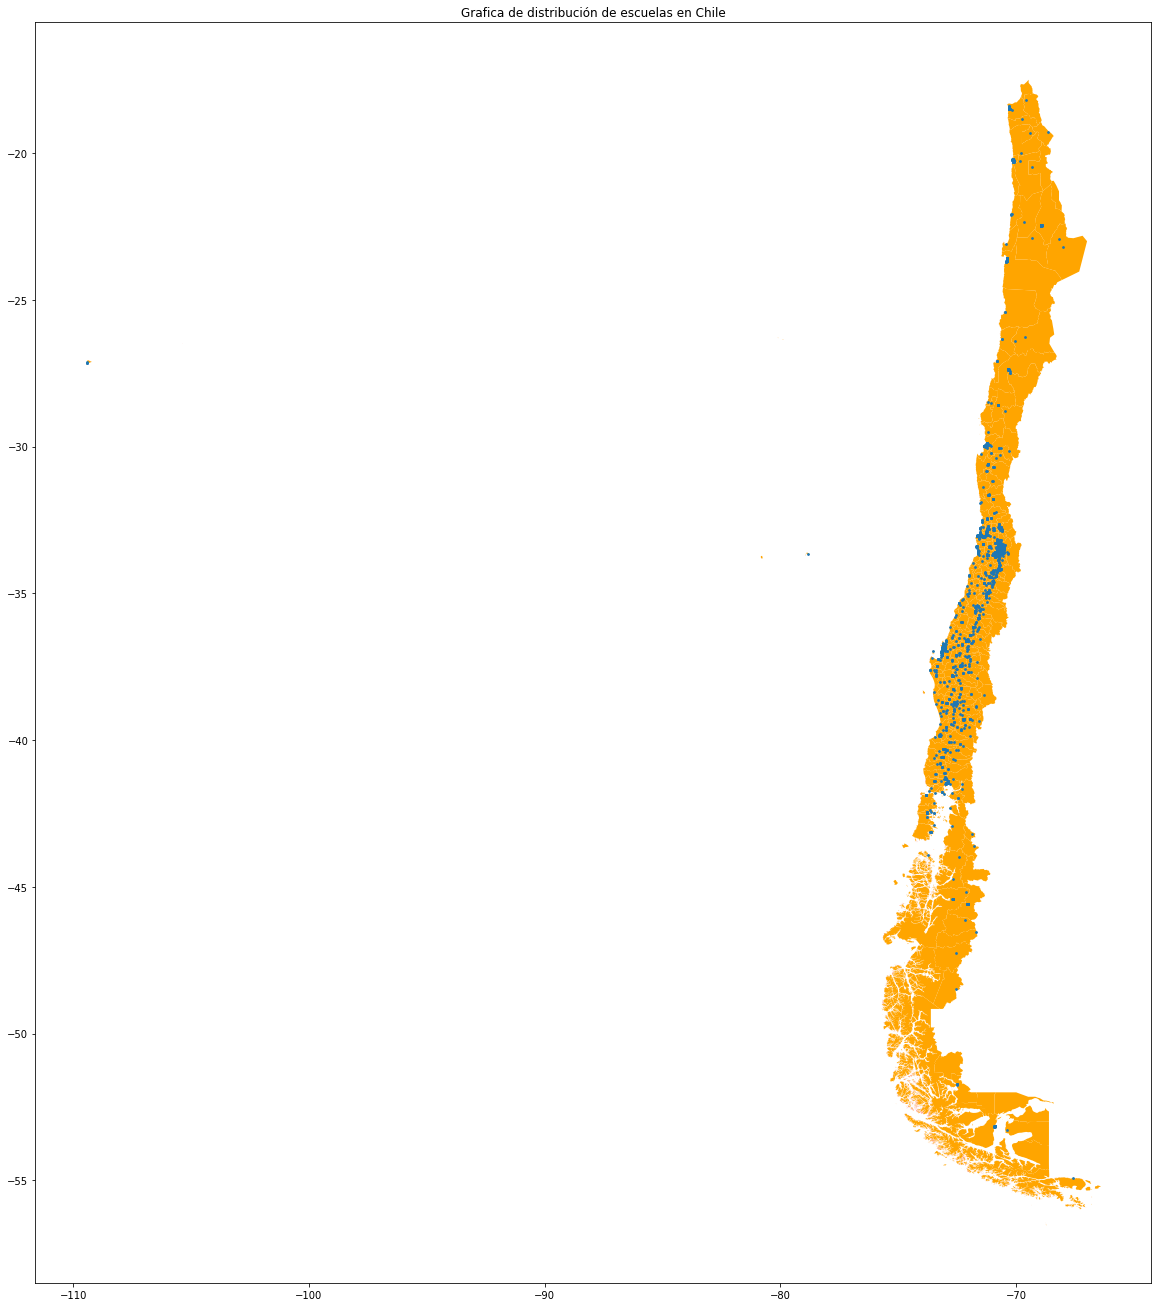

In [20]:
ruta_cartografia = path.join("DivisionPoliticoAdministrativa2020", "COMUNA", "COMUNAS_2020.shp")
comunas = gpd.read_file(ruta_cartografia).to_crs(4326)
# y ploteamos los datos del geodataframe
plot_mapa = comunas.plot(color = "orange", figsize=(20, 50))
datos_compacto_2021.plot(ax = plot_mapa, markersize=3)
plot_mapa.set_title("Grafica de distribución de escuelas en Chile")

In [21]:
geometry = datos_compacto_2021["geometry"]

In [22]:
datos_compacto_2021.drop("geometry", axis = 1, inplace=True)

C:\Users\snmar\AppData\Local\Temp\ipykernel_30700\3808821859.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_compacto_2021.drop("geometry", axis = 1, inplace=True)


In [23]:
subencion = pd.read_csv("20220509_Detalle Subvenciones 2021_20220413.csv", sep=";", encoding="ISO-8859-1")

In [24]:
ingreso = pd.read_csv("Ingresos_medios_2010-2021.csv", sep=",")

In [25]:
subencion

,AGNO,RBD,NOM_RBD,rut_sostenedor,nom_sostenedor,COD_REG_RBD,NOM_REG_RBD_A,COD_PRO_RBD,COD_COM_RBD,NOM_COM_RBD,...,subv_normal,sep_prio,sep_pref,mantenimiento,sned,avdi,aep,proretencion,adeco,reforzamiento
0,2021,1,LICEO POLITECNICO ARICA,62000660,SERVICIO LOCAL DE EDUCACIÓN PÚBLICA DE CHINCHORRO,15,AYP,151,15101,ARICA,...,67323723,10133238,990868,8239440,0,0,0,0,0,0
1,2021,1,LICEO POLITECNICO ARICA,62000660,SERVICIO LOCAL DE EDUCACIÓN PÚBLICA DE CHINCHORRO,15,AYP,151,15101,ARICA,...,67323723,10088459,990868,0,0,0,0,0,0,0
2,2021,1,LICEO POLITECNICO ARICA,62000660,SERVICIO LOCAL DE EDUCACIÓN PÚBLICA DE CHINCHORRO,15,AYP,151,15101,ARICA,...,67323723,10088459,990868,0,0,0,0,0,0,0
3,2021,1,LICEO POLITECNICO ARICA,62000660,SERVICIO LOCAL DE EDUCACIÓN PÚBLICA DE CHINCHORRO,15,AYP,151,15101,ARICA,...,70606496,10332927,990868,0,0,0,0,0,0,0
4,2021,1,LICEO POLITECNICO ARICA,62000660,SERVICIO LOCAL DE EDUCACIÓN PÚBLICA DE CHINCHORRO,15,AYP,151,15101,ARICA,...,71049368,10304152,990868,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127187,2021,42007,ESCUELA ESPECIAL DE LENGUAJE SAN CARLOS,65155045,FUNDACIÓN EDUCACIONAL MANANTIALES,8,BBIO,57,5701,SAN FELIPE,...,0,0,0,0,0,0,0,0,0,0
127188,2021,42007,ESCUELA ESPECIAL DE LENGUAJE SAN CARLOS,65155045,FUNDACIÓN EDUCACIONAL MANANTIALES,8,BBIO,57,5701,SAN FELIPE,...,0,0,0,0,0,0,0,0,0,0
127189,2021,42007,ESCUELA ESPECIAL DE LENGUAJE SAN CARLOS,65155045,FUNDACIÓN EDUCACIONAL MANANTIALES,8,BBIO,57,5701,SAN FELIPE,...,0,0,0,0,0,0,0,0,0,0
127190,2021,42007,ESCUELA ESPECIAL DE LENGUAJE SAN CARLOS,65155045,FUNDACIÓN EDUCACIONAL MANANTIALES,8,BBIO,57,5701,SAN FELIPE,...,0,0,0,0,0,0,0,0,0,0


In [26]:
subencion = subencion.groupby("NOM_RBD").mean().reset_index()
subencion.drop(["AGNO", "RBD", "COD_REG_RBD", "COD_PRO_RBD", "COD_COM_RBD"], axis = 1, inplace = True)

In [27]:
ingreso = ingreso[ingreso["agno"] == 2021]

In [28]:
ingreso.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17 entries, 187 to 203
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   agno         17 non-null     int64  
 1   region       17 non-null     int64  
 2   ingre_medio  17 non-null     float64
 3   inter_inf    17 non-null     float64
 4   inter_sup    17 non-null     float64
 5   calidad      17 non-null     object 
dtypes: float64(3), int64(2), object(1)
memory usage: 952.0+ bytes


In [29]:
ingreso

,agno,region,ingre_medio,inter_inf,inter_sup,calidad
187,2021,0,681039.367826,659911.349362,702167.386290,fiable
188,2021,15,582645.934570,542833.012122,622458.857018,fiable
189,2021,1,672108.633436,575926.507059,768290.759814,fiable
190,2021,2,765318.446479,706020.665904,824616.227053,fiable
191,2021,3,649945.591950,612157.643466,687733.540435,fiable
192,2021,4,603089.497959,538980.876076,667198.119842,fiable
193,2021,5,601402.313114,571322.193413,631482.432815,fiable
194,2021,13,780453.869641,738022.903916,822884.835365,fiable
195,2021,6,567720.762942,472313.315962,663128.209922,fiable
196,2021,7,534284.050605,500519.668955,568048.432255,fiable


In [30]:
ingreso.rename(columns={"region":"COD_REG_RBD"}, inplace = True)

In [31]:
ingreso = ingreso[["COD_REG_RBD", "ingre_medio"]]

In [32]:
datos_compacto_2021 = datos_compacto_2021.merge(subencion, on = "NOM_RBD")

In [33]:
datos_compacto_2021 = datos_compacto_2021.merge(ingreso, on = "COD_REG_RBD")

In [34]:
datos_compacto_2021

,AGNO,RBD,NOM_RBD,COD_REG_RBD,COD_PRO_RBD,COD_COM_RBD,NOM_COM_RBD,NEM,AGNO_EGRESO,rut_sostenedor,...,sep_prio,sep_pref,mantenimiento,sned,avdi,aep,proretencion,adeco,reforzamiento,ingre_medio
0,2021,1,LICEO POLITECNICO ARICA,15,151,15101,ARICA,5.488641,2021.0,62000660.0,...,1.116406e+07,1.050234e+06,6.866200e+05,0.00,0.0,0.0,0.000000e+00,0.0,0.0,582645.934570
1,2021,4,LICEO OCTAVIO PALMA PEREZ,15,151,15101,ARICA,6.200546,2021.0,62000660.0,...,2.276325e+07,5.063634e+06,1.204232e+06,0.00,0.0,0.0,3.364534e+06,821779.5,0.0,582645.934570
2,2021,5,JOVINA NARANJO FERNANDEZ,15,151,15101,ARICA,6.240480,2021.0,62000660.0,...,1.641394e+07,4.904350e+06,1.199767e+06,0.00,0.0,0.0,0.000000e+00,0.0,0.0,582645.934570
3,2021,7,L. POLI. ANTONIO VARAS DE LA BARRA,15,151,15101,ARICA,5.617087,2021.0,62000660.0,...,3.145523e+07,3.434884e+06,1.499465e+06,0.00,0.0,0.0,0.000000e+00,0.0,0.0,582645.934570
4,2021,8,COLEGIO INTEGRADO EDUARDO FREI MONTALVA,15,151,15101,ARICA,5.612941,2021.0,62000660.0,...,1.874925e+07,2.962902e+06,9.219342e+05,0.00,0.0,0.0,1.080688e+06,0.0,0.0,582645.934570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2488,2021,20278,ESCUELA ESPECIAL HOSPITALARIA REVIVIR,9,91,9120,VILLARRICA,5.400000,2021.0,65155183.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.00,0.0,0.0,9.005917e+03,0.0,0.0,533857.754275
2489,2021,20290,COLEGIO THE FOREST SCHOOL,9,91,9114,PITRUFQUÉN,5.930357,2021.0,65115066.0,...,2.202099e+07,5.961047e+06,8.610565e+05,0.00,0.0,0.0,1.077090e+06,0.0,0.0,533857.754275
2490,2021,40110,COLEGIO SAINT MATTHEW,9,91,9120,VILLARRICA,6.074583,2021.0,65144612.0,...,2.005206e+07,5.413998e+06,9.383725e+05,4072301.25,0.0,0.0,0.000000e+00,0.0,0.0,533857.754275
2491,2021,41417,ESCUELA HOSPITALARIA DE ANGOL,9,92,9201,ANGOL,5.600000,2021.0,65161863.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.00,0.0,0.0,0.000000e+00,0.0,0.0,533857.754275


In [35]:
datos_compacto_2021 = datos_compacto_2021[['AGNO', 'RBD', 'NOM_RBD', 'COD_REG_RBD', 'COD_PRO_RBD', 'COD_COM_RBD', 'NOM_COM_RBD', 'NEM', 'AGNO_EGRESO', "subv_normal", "ingre_medio"]]

In [36]:
datos_compacto_2021

,AGNO,RBD,NOM_RBD,COD_REG_RBD,COD_PRO_RBD,COD_COM_RBD,NOM_COM_RBD,NEM,AGNO_EGRESO,subv_normal,ingre_medio
0,2021,1,LICEO POLITECNICO ARICA,15,151,15101,ARICA,5.488641,2021.0,7.234019e+07,582645.934570
1,2021,4,LICEO OCTAVIO PALMA PEREZ,15,151,15101,ARICA,6.200546,2021.0,1.274158e+08,582645.934570
2,2021,5,JOVINA NARANJO FERNANDEZ,15,151,15101,ARICA,6.240480,2021.0,1.140461e+08,582645.934570
3,2021,7,L. POLI. ANTONIO VARAS DE LA BARRA,15,151,15101,ARICA,5.617087,2021.0,1.522742e+08,582645.934570
4,2021,8,COLEGIO INTEGRADO EDUARDO FREI MONTALVA,15,151,15101,ARICA,5.612941,2021.0,9.943901e+07,582645.934570
...,...,...,...,...,...,...,...,...,...,...,...
2488,2021,20278,ESCUELA ESPECIAL HOSPITALARIA REVIVIR,9,91,9120,VILLARRICA,5.400000,2021.0,1.391143e+07,533857.754275
2489,2021,20290,COLEGIO THE FOREST SCHOOL,9,91,9114,PITRUFQUÉN,5.930357,2021.0,7.927764e+07,533857.754275
2490,2021,40110,COLEGIO SAINT MATTHEW,9,91,9120,VILLARRICA,6.074583,2021.0,9.032442e+07,533857.754275
2491,2021,41417,ESCUELA HOSPITALARIA DE ANGOL,9,92,9201,ANGOL,5.600000,2021.0,3.199724e+06,533857.754275


In [37]:
scaler = StandardScaler()
data_sc = scaler.fit_transform(datos_compacto_2021[["AGNO", "NEM", "subv_normal", "ingre_medio"]])
data_sc

array([[ 0.        , -1.24608269, -0.05945235, -0.66892712],
       [ 0.        ,  1.48347436,  1.09768353, -0.66892712],
       [ 0.        ,  1.63658674,  0.81678642, -0.66892712],
       ...,
       [ 0.        ,  1.00051292,  0.31839584, -1.14338249],
       [ 0.        , -0.81911398, -1.51209117, -1.14338249],
       [ 0.        ,  0.77206108, -1.50022512, -1.14338249]])

In [38]:
inertia=[]
kmax=20
for i in range(1,kmax):

    kmeans = KMeans(n_clusters=i,n_init=10)
    kncl= kmeans.fit(data_sc)

    print(i,kncl.inertia_)
    inertia.append(kncl.inertia_)

1 7478.999999999999
2 5125.581658457357
3 3974.5600500210926
4 3084.0875020021044
5 2492.5836066497864
6 2156.22930281939
7 1941.9874620257256
8 1739.6711356056796
9 1592.2359505092743
10 1447.4955034207858
11 1353.2186922972805
12 1274.1243938975479
13 1202.7972794104985
14 1131.2323104334362
15 1079.8942287866591
16 1011.3110328050327
17 972.740591510396
18 933.7489422824664
19 896.3461210051578


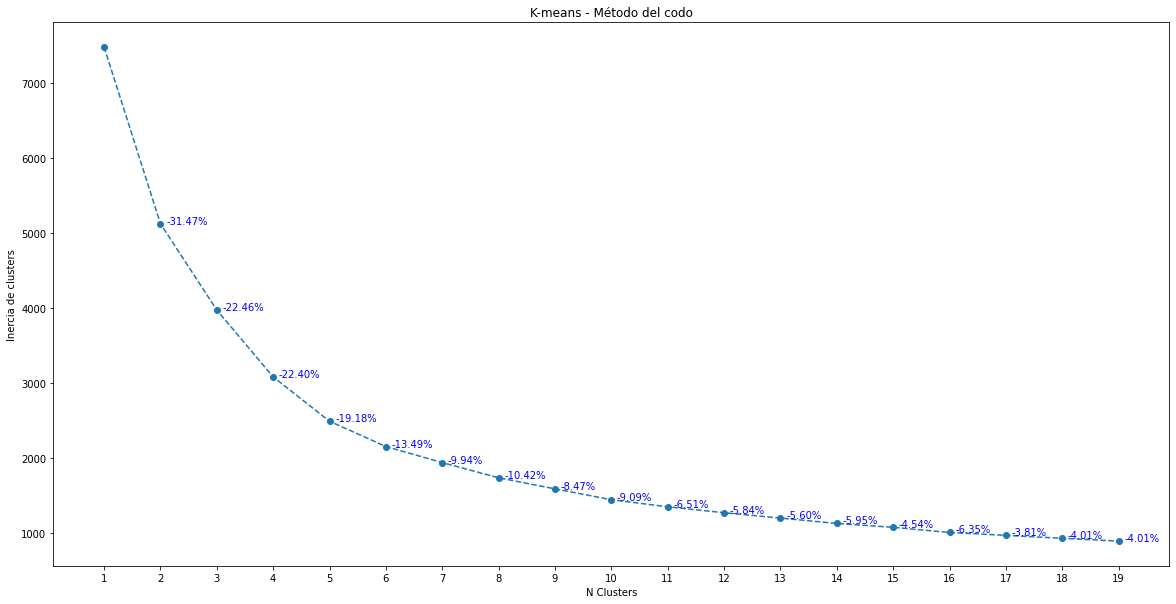

In [39]:
f, ax = plt.subplots(1,1, figsize=(20,10))

ax.plot(range(1,kmax),inertia,marker='o',ls='--')
ax.set_xlabel('N Clusters')
ax.set_ylabel('Inercia de clusters')
ax.set_title('K-means - Método del codo')

for i in range(1,len(inertia)):
    delta=(-inertia[i-1]+inertia[i])/inertia[i-1]*100
    ax.text(i+1.1,inertia[i],'%.2f'%delta+'%',color='b')
ax.set_xticks(range(1,kmax))

plt.show()

In [40]:
k=5

# Inicializamos la instancia  KMeans 
kmeans = KMeans(n_clusters=k,random_state=0)


# Correr el algoritmo sobre el conjunto de variable normalizadas
kcls = kmeans.fit(data_sc)


In [41]:
datos_compacto_2021['kcls_labels'] = kcls.labels_

C:\Users\snmar\AppData\Local\Temp\ipykernel_30700\2982018670.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_compacto_2021['kcls_labels'] = kcls.labels_


In [42]:
centers = kcls.cluster_centers_
centers_i = scaler.inverse_transform(centers)

centers_i

array([[2.02100000e+03, 5.62444643e+00, 5.13769764e+07, 5.71604792e+05],
       [2.02100000e+03, 6.01726990e+00, 7.38216548e+07, 7.80427794e+05],
       [2.02100000e+03, 5.57133682e+00, 6.26626215e+07, 7.78644793e+05],
       [2.02100000e+03, 6.03753442e+00, 7.37784268e+07, 5.75727869e+05],
       [2.02100000e+03, 5.82507983e+00, 1.81110683e+08, 6.64001370e+05]])

In [43]:
datos_compacto_2021["geometry"] = geometry

C:\Users\snmar\AppData\Local\Temp\ipykernel_30700\2466025196.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_compacto_2021["geometry"] = geometry


In [44]:
datos_compacto_2021 = gpd.GeoDataFrame(datos_compacto_2021)

Text(0.5, 1.0, 'Grafica de distribución de escuelas en Chile')

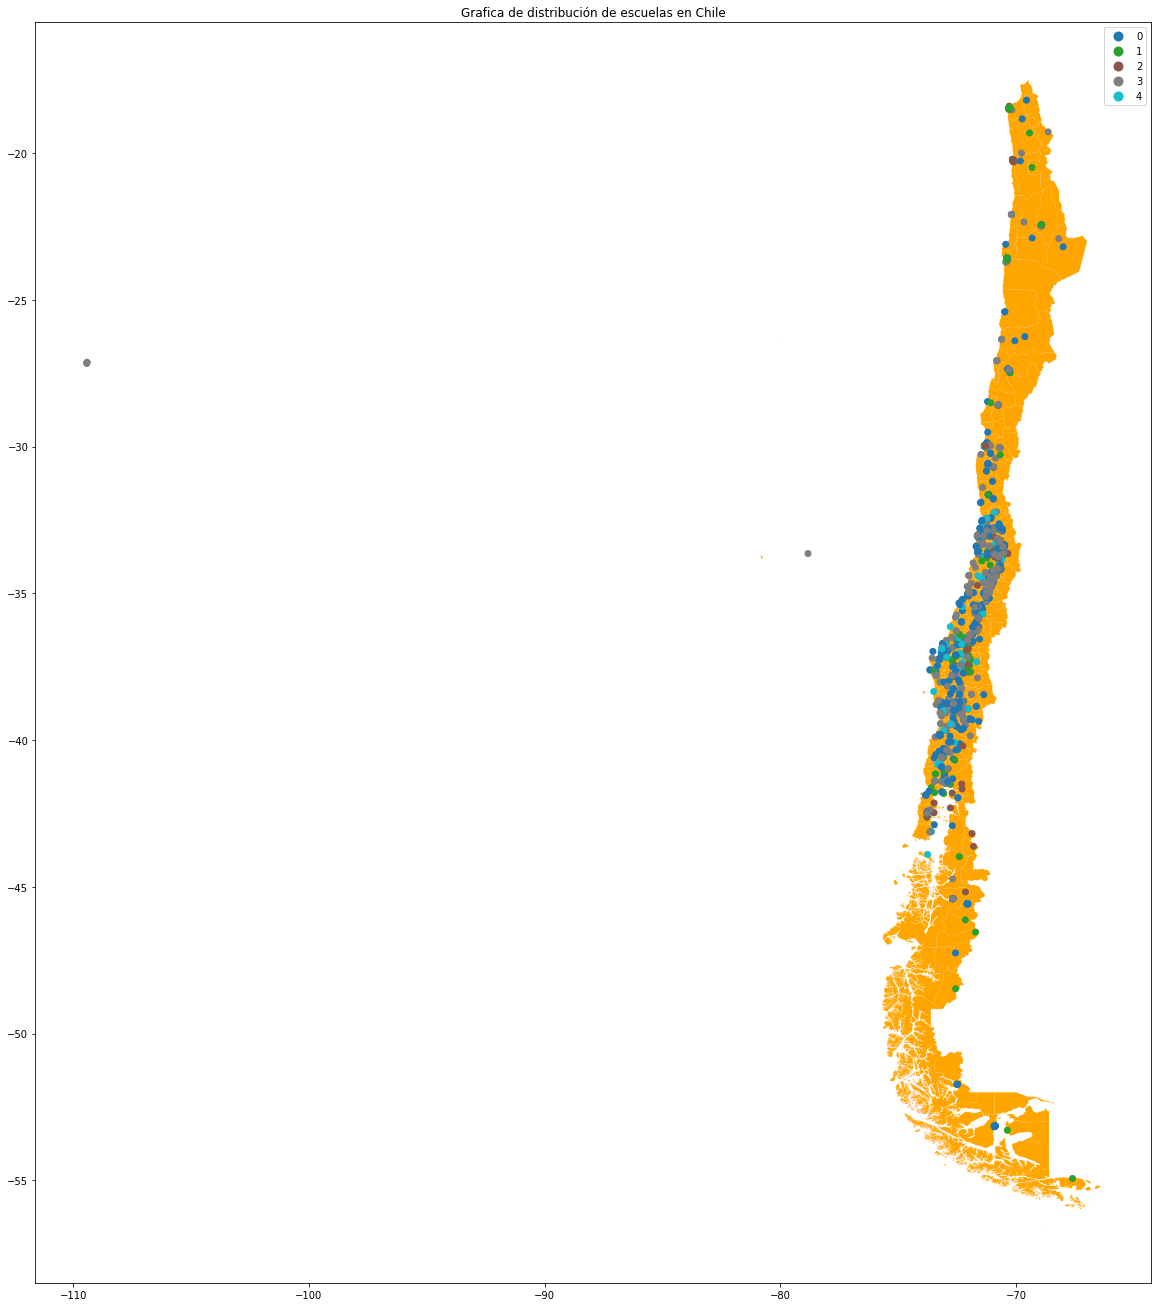

In [45]:
ruta_cartografia = path.join("DivisionPoliticoAdministrativa2020", "COMUNA", "COMUNAS_2020.shp")
comunas = gpd.read_file(ruta_cartografia).to_crs(4326)
# y ploteamos los datos del geodataframe
plot_mapa = comunas.plot(color = "orange", figsize=(20, 50))
datos_compacto_2021.plot(ax = plot_mapa, column = "kcls_labels", categorical = True, legend = True)
plot_mapa.set_title("Grafica de distribución de escuelas en Chile")



In [46]:
values = datos_compacto_2021.groupby(by = "kcls_labels").mean().sort_values(by="NEM")
datos_compacto_2021.groupby(by = "kcls_labels").mean().sort_values(by="NEM")[["AGNO", "NEM", "subv_normal", "ingre_medio"]]

,AGNO,NEM,subv_normal,ingre_medio
kcls_labels,,,,
2,2021.0,5.571337,6.266262e+07,778644.792761
0,2021.0,5.623917,5.131761e+07,571605.545924
4,2021.0,5.825080,1.811107e+08,664001.370093
1,2021.0,6.017270,7.382165e+07,780427.793806
3,2021.0,6.036901,7.377549e+07,575715.366650


In [47]:
datos_compacto_2021

,AGNO,RBD,NOM_RBD,COD_REG_RBD,COD_PRO_RBD,COD_COM_RBD,NOM_COM_RBD,NEM,AGNO_EGRESO,subv_normal,ingre_medio,kcls_labels,geometry
0,2021,1,LICEO POLITECNICO ARICA,15,151,15101,ARICA,5.488641,2021.0,7.234019e+07,582645.934570,0,POINT (-70.29521 -18.48720)
1,2021,4,LICEO OCTAVIO PALMA PEREZ,15,151,15101,ARICA,6.200546,2021.0,1.274158e+08,582645.934570,3,POINT (-70.30827 -18.47424)
2,2021,5,JOVINA NARANJO FERNANDEZ,15,151,15101,ARICA,6.240480,2021.0,1.140461e+08,582645.934570,3,POINT (-70.31345 -18.47690)
3,2021,7,L. POLI. ANTONIO VARAS DE LA BARRA,15,151,15101,ARICA,5.617087,2021.0,1.522742e+08,582645.934570,4,POINT (-70.28837 -18.47615)
4,2021,8,COLEGIO INTEGRADO EDUARDO FREI MONTALVA,15,151,15101,ARICA,5.612941,2021.0,9.943901e+07,582645.934570,0,POINT (-70.31758 -18.48249)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2488,2021,20278,ESCUELA ESPECIAL HOSPITALARIA REVIVIR,9,91,9120,VILLARRICA,5.400000,2021.0,1.391143e+07,533857.754275,0,POINT (-70.58909 -33.53769)
2489,2021,20290,COLEGIO THE FOREST SCHOOL,9,91,9114,PITRUFQUÉN,5.930357,2021.0,7.927764e+07,533857.754275,3,POINT (-70.72075 -33.36114)
2490,2021,40110,COLEGIO SAINT MATTHEW,9,91,9120,VILLARRICA,6.074583,2021.0,9.032442e+07,533857.754275,3,POINT (-70.57308 -33.63036)
2491,2021,41417,ESCUELA HOSPITALARIA DE ANGOL,9,92,9201,ANGOL,5.600000,2021.0,3.199724e+06,533857.754275,0,POINT (-70.73323 -33.46512)
